In [26]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Libreria surprise para entrenamiento
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

In [27]:
# Cargar el conjunto de datos de scores
df = pd.read_csv("datasets/scores.csv")

# Cargar el conjunto de datos de movies para sacar luego el titulo de las peliculas
df_titles = pd.read_csv("datasets/movies_titles.csv")

In [28]:
# Del dataset de peliculas solo nos interesa quedarnos con el id y su titulo

df_titles = df_titles[['id','title']]

df_titles = df_titles.reset_index(drop=True)

df_titles

,id,title
0,as1,the grand seduction
1,as2,take care good night
2,as3,secrets of deception
3,as4,pink: staying true
4,as5,monster maker
...,...,...
22993,ns8803,zodiac
22994,ns8804,zombie dumb
22995,ns8805,zombieland
22996,ns8806,zoom


In [29]:
# Pasos previos a realización de la predicción

N_filas = 100000 # Limitamos el dataset a N_filas

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['userId', 'movieId', 'score']][:N_filas], reader)

# Separamos nuestros datos

trainset, testset = train_test_split(data, test_size=.25)


In [30]:
# Entrenamos el modelo SVD

model = SVD()

model.fit(trainset)

In [31]:
# Predecimos

predictions = model.test(testset)

In [32]:
predictions[1]

Prediction(uid=1699, iid='ns6680', r_ui=3.0, est=3.64434907566305, details={'was_impossible': False})

In [33]:
# Hacemos una predicción con userId y movieId al azar

model.predict(9, 'ns5709')

Prediction(uid=9, iid='ns5709', r_ui=None, est=4.133783080371793, details={'was_impossible': False})

### Predicción completa para un usuario aleatorio

In [34]:
# Tomaremos un usuario al azar para hacerle una recomendación

usuario = 44200
score = 4  # Tomamos películas a las que haya calificado con 4 o 5 estrellas
df_user = df[(df.userId == usuario) & (df.score >= score)]

df_user = df_user.reset_index(drop=True)

df_titles.rename(columns={'id': 'movieId'}, inplace=True)

df_user = pd.merge(df_user, df_titles[['movieId', 'title']], left_on='movieId', right_on='movieId', how='left')

df_user

,userId,score,timestamp,movieId,title
0,44200,5.0,2013-11-10,as6154,paranormal
1,44200,5.0,2013-11-04,ns1757,lego jurassic world: legend of isla nublar
2,44200,5.0,2013-11-04,ds360,planes
3,44200,4.0,2015-11-07,as149,water (short)
4,44200,4.0,2014-10-18,as9420,the sacrament
...,...,...,...,...,...
192,44200,4.5,2016-03-09,ns3960,mercy black
193,44200,4.0,2016-03-09,as9069,the joyriders
194,44200,4.0,2016-03-09,ns2761,kannum kannum kollaiyadithaal
195,44200,4.5,2016-03-09,hs697,vanguard


In [35]:
recomendaciones_usuario = df_titles.iloc[:23000].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(22998, 2)


,movieId,title
0,as1,the grand seduction
1,as2,take care good night
2,as3,secrets of deception
3,as4,pink: staying true
4,as5,monster maker


In [36]:
# Debemos extraer las películas que ya ha visto

usuario_vistas = df[df['userId'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(337, 4)


,userId,score,timestamp,movieId
4254853,44200,3.5,2013-11-12,as4033
4254854,44200,5.0,2013-11-10,as6154
4254855,44200,5.0,2013-11-04,ns1757
4254856,44200,5.0,2013-11-04,ds360
4254857,44200,3.0,2013-11-23,hs2132


In [37]:
# Eliminamos las peliculas que el usuario ya vió

recomendaciones_usuario = recomendaciones_usuario[~recomendaciones_usuario['movieId'].isin(usuario_vistas['movieId'])]

recomendaciones_usuario.shape

(22663, 2)

In [38]:
# Recomendamos

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['movieId'].apply(lambda x: model.predict(usuario, x).est)

In [39]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

      movieId                 title  Estimate_Score
8231   as8232     the wheel of time        4.155093
11296   hs179          the simpsons        4.118489
3056   as3057    black lives matter        4.061354
20127  ns5937     shrek the musical        4.057249
15027   ns837             ghost lab        4.053570
16748  ns2558         scissor seven        4.049704
13562  hs2445                casual        4.046605
19366  ns5176         lady dynamite        4.034041
22397  ns8207              the beat        4.033227
110     as111  who killed doc robin        4.022706


## Evaluación del modelo

In [42]:
# Evaluamos el accuracy del modelo

from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.9682


0.9681631718134432

### Optimización de los hiperparametros

In [43]:
from surprise.model_selection import cross_validate
import numpy as np

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9529  0.9584  0.9592  0.9568  0.0028  
Fit time          1.03    0.94    0.92    0.96    0.05    
Test time         0.75    0.66    0.56    0.66    0.08    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9574  0.9543  0.9557  0.9558  0.0013  
Fit time          0.88    0.90    0.91    0.90    0.01    
Test time         0.59    0.58    0.62    0.60    0.02    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9545  0.9583  0.9591  0.9573  0.0020  
Fit time          0.91    0.93    1.30    1.05    0.18    
Test time         0.41    0.41    0.50    0.44    0.04    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9588  0.9

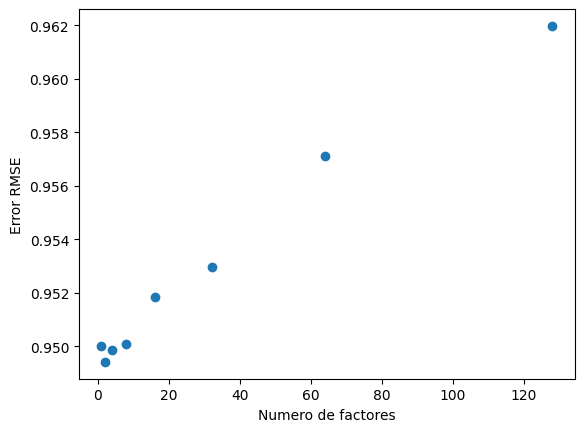

In [ ]:
# Ploteamos desempeño según cantidad de factores de SVD

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

### Predicción ingresando un id de usuario y uno de pelicula

In [40]:
def get_movie_recommendation(userId, movieId):
    # Obtenemos la predicción de la calificación que el usuario le daría a la película
    prediction = model.predict(userId, str(movieId))
    
    # Verificar si el id de la película existe en df_title
    if movieId not in df_titles.movieId.values:
      return 'La película con el id ingresado no existe.', movieId

    # Verificar si el userId del usuario existe
    if userId not in df.userId.values:
      return 'El usuario con el id ingresado no existe.', userId
    
    # Si la predicción es mayor o igual a 3.5, se recomienda la película
    if prediction.est >= 3.5:
        return "Recomendada", prediction.est
    else:
        return "No recomendada", prediction.est

In [41]:
# Ejemplo del funcionamiento de get_movie_recommendation

# ID del usuario
user_id = 12
# ID de la película
movie_id = 'as12'

# Obtener la recomendación para el usuario y la película
recommendation = get_movie_recommendation(user_id, movie_id)

# Imprimir la recomendación
print("La película es:", recommendation)

La película es: ('Recomendada', 3.950838305289089)


In [ ]:
# Esta función la creamos con el fin de saber el titulo de la pelicula que recomendamos o no

def get_movie_title(movieId):
    return df_titles[df_titles.movieId == movieId].title.iloc[0].title()

In [ ]:
# Probamos la función
get_movie_title('as113')

'Whitechapel'

In [ ]:
# Utilizaremos la funcion "get_movie_recommendation" previamente declarada 
# y la de get_movie_title recientemente declarada para crear una nueva función combinada

def combined_functions(userId, movieId):
    # Verificar si el id de la película existe en df_title
    if movieId not in df_titles.movieId.values:
      return ('La pelicula con el id ingresado no existe.', 0, '')
    # Verificar si el userId del usuario existe 
    elif userId not in df.userId.values:
      return ('El usuario con el id ingresado no existe.', 0, '')
    else:          
        recommended, score = get_movie_recommendation(userId, movieId)
        title = get_movie_title(movieId)
        return (recommended, score, title)


In [ ]:
combined_functions(1, 'as11')

('Recomendada', 4.210412420284361, 'Forest Fairies')

# Interfaz de usuario mediante gradio

In [ ]:
# Importo la libreria de gradio para hacer la interfaz
import gradio as gr

In [ ]:
title = str("Sistema de recomendación de peliculas")

with gr.Blocks(title= title) as demo:
    text = gr.components.HTML("""
    <h1>Bienvenido al sistema de recomendación de peliculas!</h1>
    """)
    userId = gr.inputs.Number(label="Ingresa tu id")
    movie = gr.Textbox(label="Ingresa una id de pelicula")
    get_recommendation_btn = gr.Button("Averigua si la pelicula es recomendada para ti")
    title = gr.Textbox(label = "Nombre de la pelicula:")
    output = gr.Textbox(label="¿Se recomienda la pelicula?")
    score = gr.Textbox(label="Score predicho:")
    get_recommendation_btn.click(fn=combined_functions, inputs=[userId,movie], outputs=[output, score, title])

demo.launch(share=True)

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://2de50613-6e2c-43a3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
